## Notebook to generate summary plot for NHANES

In [1]:
import xgboost, shap, os, scipy, sklearn, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

# Load data
from deepshap.data import load_nhanes, get_nhanes_feat_names
trainx, trainy, _, _, testx, testy = load_nhanes()
feat_names = get_nhanes_feat_names()

# Load model
from model import nhanes_mlp
model = nhanes_mlp()

Using TensorFlow backend.
W1007 12:32:45.078762 139882561857344 deprecation.py:323] From /homes/gws/hughchen/anaconda2/envs/tf36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


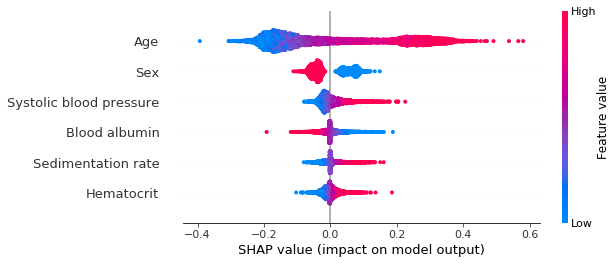

In [2]:
RAND_ATTR_PATH = "attr/rand1000bg.npy"

if not os.path.exists(RAND_ATTR_PATH):
    n = trainx.shape[0]; ref_size = 1000
    
    # Randomly sample background
    np.random.seed(10)
    refe_inds = np.random.choice(n,ref_size,replace=False)
    refe = trainx[refe_inds]
    expl = shap.DeepExplainer(model, refe)
    attr = expl.shap_values(trainx)[0]
    
    # Check for local accuracy/efficiency
    pred_minus_base = (model.predict(trainx) - 
                       model.predict(refe).mean())[:,0]
    assert np.allclose(pred_minus_base, attr.sum(1), atol=1e-4)
    
    # Save the attributions
    np.save(RAND_ATTR_PATH, attr)
else:
    attr = np.load(RAND_ATTR_PATH)

# Summary plot
shap.summary_plot(attr, features=trainx, feature_names=feat_names, max_display=6, show=False)
plt.savefig("fig/summary.pdf")